# Soft-Prompt Experiment Notebook

This notebook orchestrates hyperparameter experiments for **Brand Voice Rewriter**.

**What it does:**  
- Runs `scripts/train_gemma_softprompt.py` multiple times with different hyperparameters.  
- Logs and aggregates metrics from `artifacts/runs/<style>/run_*.json`.  
- Picks the best configurations by validation proxies (time/seconds, etc.) and your custom metrics.  
- Optionally renders visualization figures using `scripts/visualize_softprompt.py`.

> **Run this notebook from the project root** (same level as `scripts/` and `config/`).  
> Requires a GPU machine for training; CPU is fine for data aggregation/plots.


In [1]:
import os, json, time, subprocess, shlex
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml

PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)

CONFIG_PATH = PROJECT_ROOT / "config" / "app.yaml"
RUNS_ROOT   = PROJECT_ROOT / "artifacts" / "softprompt"
FIG_ROOT = PROJECT_ROOT / "artifacts" / "reports" / "figures"
FIG_ROOT.mkdir(parents=True, exist_ok=True)

TEST_CSV    = PROJECT_ROOT / "data" / "datasets" / "neutral_texts.csv"
SOFTP_ROOT  = None

cfg = yaml.safe_load(open(CONFIG_PATH, "r", encoding="utf-8"))
BASE_MODEL_ID = cfg["model_id"]

STYLES = ["fintech", "compliance", "motivation_guru", "ai_newsletter"]

print("Working dir:", PROJECT_ROOT)
print("Config:", CONFIG_PATH)
print("Runs root:", RUNS_ROOT)


Working dir: /root/brand-voice-writer
Config: /root/brand-voice-writer/config/app.yaml
Runs root: /root/brand-voice-writer/artifacts/softprompt


## Choose style and search space

In [2]:
# We'll compute grad_accum to hit eff_batch ~ 32.
PER_DEVICE_BSZ = 4           # set 2 on 16GB T4, 4 on 24GB L4/A10
EFF_BATCH      = 4
GRAD_ACCUM     = max(1, EFF_BATCH // PER_DEVICE_BSZ)

# === Search grid (coarse) ===
V_CHOICES   = [8]
SEQ_CHOICES = [64]
LR_CHOICES  = [1e-3]
EPOCHS      = [5]

# Initialization prompt variants (short style hints)
INIT_PROMPTS = {
    "TEXT_neutral": "[rewrite]"
}
INIT_KEYS = list(INIT_PROMPTS.keys())

print("grad_accum:", GRAD_ACCUM, "(per_device_bsz:", PER_DEVICE_BSZ, ")")


grad_accum: 1 (per_device_bsz: 4 )


## Run a single training trial

In [3]:
def run_trial(style:str, vtok:int, seq_len:int, lr:float, epochs:int, bsz:int, grad_accum:int, init_key:str):
    """Launch a single training run via CLI. Returns (ok, stdout, stderr)."""
    # We pass extra env to override init_text inside your trainer (if supported).
    env = os.environ.copy()
    env["PYTHONPATH"] = str(PROJECT_ROOT)
    env["BVW_INIT_TEXT_VARIANT"] = init_key  # your trainer can read this to choose init

    cmd = f"python scripts/train_gemma_softprompt.py --style {style} --virtual-tokens {vtok} --max-seq-len {seq_len} --lr {lr} --epochs {epochs} --bsz {bsz}"

    # If your trainer supports grad_accum and checkpointing flags, add them here:
    # cmd += f" --grad-accum {grad_accum} --ckpt"

    print("\n[RUN]", cmd)
    start = time.time()
    proc = subprocess.run(shlex.split(cmd), cwd=PROJECT_ROOT, capture_output=True, text=True, env=env)
    dur = time.time() - start
    ok = proc.returncode == 0
    print(proc.stdout)
    if not ok:
        print("[ERR]", proc.stderr)
    return ok, proc.stdout, proc.stderr, dur


## Launch coarse grid search

In [4]:
results = []
for v in V_CHOICES:
    for seql in SEQ_CHOICES:
        for lrate in LR_CHOICES:
            for init_key in INIT_KEYS:
                for STYLE in STYLES:
                
                    ok, out, err, dur = run_trial(
                        style=STYLE, vtok=v, seq_len=seql, lr=lrate, epochs=EPOCHS[0],
                        bsz=PER_DEVICE_BSZ, grad_accum=GRAD_ACCUM, init_key=init_key
                    )
                    results.append({
                        "style": STYLE, "vtok": v, "seq_len": seql, "lr": lrate, "epochs": EPOCHS[0],
                        "per_device_bsz": PER_DEVICE_BSZ, "grad_accum": GRAD_ACCUM, "duration_sec": round(dur,2),
                        "ok": ok
                    })

df = pd.DataFrame(results)


[RUN] python scripts/train_gemma_softprompt.py --style fintech --virtual-tokens 8 --max-seq-len 64 --lr 0.001 --epochs 5 --bsz 4
[load_model] Loaded Qwen/Qwen2.5-1.5B-Instruct from LOCAL cache (.hf_cache) on cpu
[CONFIG] style=fintech vtok=8 epochs=5 bsz=4 lr=0.001 max_seq_len=64 device=cpu
[RUN_DIR] Saving adapter + logs to artifacts/softprompt/fintech/run_002
trainable params: 12,288 || all params: 1,543,726,592 || trainable%: 0.0008
{'loss': 6.0023, 'grad_norm': 1.804671287536621, 'learning_rate': 0.00088, 'epoch': 0.67}
{'loss': 4.7791, 'grad_norm': 1.9402457475662231, 'learning_rate': 0.0007466666666666667, 'epoch': 1.33}
{'loss': 5.1683, 'grad_norm': 2.030022382736206, 'learning_rate': 0.0006133333333333334, 'epoch': 2.0}
{'loss': 5.179, 'grad_norm': 4.933825969696045, 'learning_rate': 0.00048, 'epoch': 2.67}
{'loss': 5.6016, 'grad_norm': 3.1343624591827393, 'learning_rate': 0.00034666666666666667, 'epoch': 3.33}
{'loss': 4.9805, 'grad_norm': 3.6371896266937256, 'learning_rate':

## Collect metrics from artifacts/runs

In [4]:
import os
from pathlib import Path
import math

import pandas as pd
import numpy as np
import torch
import yaml
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt


df_base = pd.read_csv(TEST_CSV)
df_base.head()


/root/brand-voice-writer/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,id,text
0,1,Our company is launching a new analytics dashb...
1,2,The new subscription plan offers access to cor...
2,3,This internal report summarizes activity acros...
3,4,The updated onboarding process aims to make it...
4,5,Our latest product update introduces minor int...


In [5]:
def get_latest_run_dir(style: str) -> Path:
    style_root = RUNS_ROOT / style
    if not style_root.exists():
        raise RuntimeError(f"No softprompt dir for style '{style}' at {style_root}")
    runs = sorted([d for d in style_root.iterdir() if d.is_dir() and d.name.startswith("run_")])
    if not runs:
        raise RuntimeError(f"No run_* dirs for style '{style}' at {style_root}")
    return runs[-1]


def load_base_model_and_tokenizer(device: str = "cpu"):
    tok = AutoTokenizer.from_pretrained(BASE_MODEL_ID, trust_remote_code=True, use_fast=True)
    dtype = torch.float16 if device == "cuda" else torch.float32
    model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_ID,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        dtype=dtype,
    ).to(device)
    model.eval()
    return tok, model


def load_style_model(style: str, base_model, device: str = "cpu"):
    run_dir = get_latest_run_dir(style)
    print(f"[LOAD] style={style} run={run_dir.name}")
    peft_model = PeftModel.from_pretrained(base_model, run_dir)
    peft_model.to(device)
    peft_model.eval()
    return peft_model


In [6]:
def rewrite_with_style(
    tok,
    styled_model,
    device: str,
    text: str,
    style: str,
    max_new_tokens: int = 160,
    temperature: float = 0.0,
    top_p: float = 0.9
) -> str:
    
    system_prompt = (
        f"You are a brand voice rewriter. "
        f"Rewrite the text into the '{style}' brand voice. "
        f"Preserve meaning and approximate length. "
        f"Your output MUST follow this EXACT format:\n"
        f"[rewrite]\n"
        f"<rewritten text here>\n"
        f"[/rewrite]\n"
        f"No explanations. No alternatives. No extra words. "
        f"DO NOT output anything outside the [rewrite] block."
    )

    prompt = (
        f"{system_prompt}\n\n"
        f"Original text:\n{text.strip()}\n\n"
        f"Rewritten text:\n"
        f"[rewrite]\n"
    )

    # Tokenize
    inputs = tok(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        out = styled_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=temperature,
            top_p=top_p,
            eos_token_id=tok.eos_token_id,
        )

    generated_ids = out[0]

    # Extract only generated continuation
    prompt_len = inputs["input_ids"].shape[1]
    gen_ids = generated_ids[prompt_len:]
    decoded = tok.decode(gen_ids, skip_special_tokens=True)

    # Normalize whitespace
    decoded = decoded.strip()

    # Extract content between tags
    if "[rewrite]" in decoded:
        decoded = decoded.split("[rewrite]", 1)[-1]
    if "[/rewrite]" in decoded:
        decoded = decoded.split("[/rewrite]", 1)[0]

    final_text = decoded.strip()

    return final_text


In [7]:
def rewrite_neutral(tok, base_model, device: str, text: str,
                    max_new_tokens: int = 160, temperature: float = 0.0, top_p: float = 0.9) -> str:
    system_prompt = (
        f"You are a brand voice rewriter. "
        f"Rewrite the text in neutral tone. "
        f"Preserve meaning and approximate length. "
        f"Your output MUST follow this EXACT format:\n"
        f"[rewrite]\n"
        f"<rewritten text here>\n"
        f"[/rewrite]\n"
        f"No explanations. No alternatives. No extra words. "
        f"DO NOT output anything outside the [rewrite] block."
    )
    #system_prompt = (f"Rewrite the input in the user's voice while preserving meaning.")
    prompt = (
            f"{system_prompt}\n\n"
            "Original text:\n"
            f"{text.strip()}\n\n"
            "Rewritten text:\n"
        )

    inputs = tok(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        out = base_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,             
            temperature=temperature,
            top_p=top_p,
            eos_token_id=tok.eos_token_id,
        )

    generated_ids = out[0]

    # Extract only generated continuation
    prompt_len = inputs["input_ids"].shape[1]
    gen_ids = generated_ids[prompt_len:]
    decoded = tok.decode(gen_ids, skip_special_tokens=True)

    # Normalize whitespace
    decoded = decoded.strip()

    # Extract content between tags
    if "[rewrite]" in decoded:
        decoded = decoded.split("[rewrite]", 1)[-1]
    if "[/rewrite]" in decoded:
        decoded = decoded.split("[/rewrite]", 1)[0]

    final_text = decoded.strip()
    
    return final_text


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
tok, base_model = load_base_model_and_tokenizer(device=device)

base_rewrites = []
for _, row in df_base.iterrows():
    txt = row["text"]
    out = rewrite_neutral(tok, base_model, device, txt)
    base_rewrites.append(out)

df_base["neutral_out"] = base_rewrites

rows = []
for style in STYLES:
    styled_model = load_style_model(style, base_model, device=device)
    for _, row in df_base.iterrows():
        sample_id = row["id"]
        src = row["text"]
        neutral = row["neutral_out"]
        styled = rewrite_with_style(tok, styled_model, device, src, style)
        rows.append({
            "id": sample_id,
            "style": style,
            "src": src,
            "neutral_out": neutral,
            "styled_out": styled,
        })

df_styles = pd.DataFrame(rows)

df_styles.to_csv('test_results_brak.csv')
df_base.to_csv('test_results_neutral_brak.csv')


[LOAD] style=fintech run=run_002


/root/brand-voice-writer/.env/lib/python3.12/site-packages/peft/peft_model.py:2066: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


[LOAD] style=compliance run=run_002
[LOAD] style=motivation_guru run=run_002
[LOAD] style=ai_newsletter run=run_002


In [8]:
df_styles = pd.read_csv('test_results_brak.csv')
df_base= pd.read_csv('test_results_neutral_brak.csv')

In [21]:
df_styles.dropna(inplace=True)

In [29]:
print(df_base[(df_base['id'] == 4)]['text'].item())


The updated onboarding process aims to make it easier for new employees to access essential tools, understand company policies, and meet key team members during their first week.


In [30]:
print(df_styles[(df_styles['style'] == 'fintech') & (df_styles['id'] == 4) ]['neutral_out'].item())

The revised orientation procedure is designed to facilitate quick access to vital resources, comprehend organizational guidelines, and establish initial connections with fellow colleagues within the first month of employment.


In [24]:
# %pip install -U sentence-transformers

emb_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def cosine_angle(v1: np.ndarray, v2: np.ndarray) -> float:
    """
    """
    v1 = v1 / (np.linalg.norm(v1) + 1e-8)
    v2 = v2 / (np.linalg.norm(v2) + 1e-8)
    cos_sim = float(np.clip(np.dot(v1, v2), -1.0, 1.0))
    angle = math.degrees(math.acos(cos_sim))
    return angle, cos_sim

angles_rows = []

for (style, sample_id), grp in df_styles.groupby(["style", "id"]):
    neutral_text = grp.iloc[0]["neutral_out"]
    styled_text = grp.iloc[0]["styled_out"]

    emb_neutral = emb_model.encode(neutral_text, convert_to_numpy=True)
    emb_styled  = emb_model.encode(styled_text, convert_to_numpy=True)

    angle_deg, cos_sim = cosine_angle(emb_neutral, emb_styled)

    angles_rows.append({
        "id": sample_id,
        "style": style,
        "angle_deg": angle_deg,
        "cosine": cos_sim,
        "embedding": emb_styled,
    })

df_angles = pd.DataFrame(angles_rows)
df_angles.head()


,id,style,angle_deg,cosine,embedding
0,1,ai_newsletter,44.942779,0.707813,"[-0.030881172, 0.0021252823, -0.020708028, 0.0..."
1,2,ai_newsletter,53.060862,0.600966,"[-0.0433264, -0.04016019, 0.0067946776, 0.0253..."
2,3,ai_newsletter,60.084832,0.498717,"[-0.048179362, -0.027131451, 0.005714076, 0.00..."
3,4,ai_newsletter,73.448179,0.284882,"[-0.091720365, -0.03237664, 0.01976119, 0.0382..."
4,5,ai_newsletter,35.980769,0.809214,"[-0.10964569, -0.024965912, 0.06753007, -0.006..."


In [25]:
df_angles.groupby(['style']).aggregate('mean')

,id,angle_deg,cosine,embedding
style,,,,
ai_newsletter,10.500000,51.406678,0.606631,"[-0.035916319489479064, -0.0038711033761501313..."
compliance,10.500000,51.722114,0.600587,"[-0.019057494401931763, 0.0059318505227565765,..."
fintech,10.823529,68.163344,0.359585,"[-0.046856827595654654, 0.04411599215339212, 0..."
motivation_guru,10.500000,54.606694,0.566486,"[-0.014708855748176574, 0.009499544650316239, ..."


<Figure size 800x500 with 0 Axes>

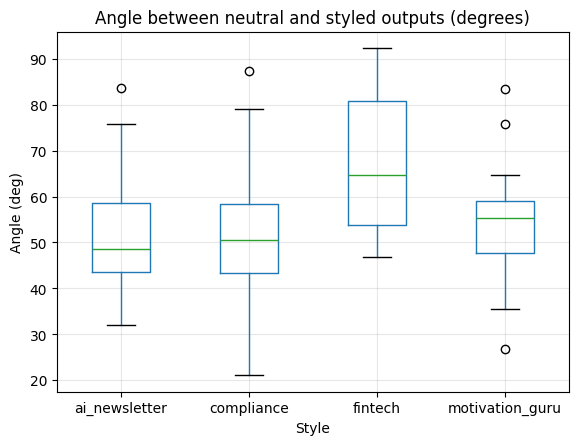

In [26]:
plt.figure(figsize=(8,5))
df_angles.boxplot(column="angle_deg", by="style")
plt.title("Angle between neutral and styled outputs (degrees)")
plt.suptitle("")
plt.ylabel("Angle (deg)")
plt.xlabel("Style")
plt.grid(alpha=0.3)
plt.show()


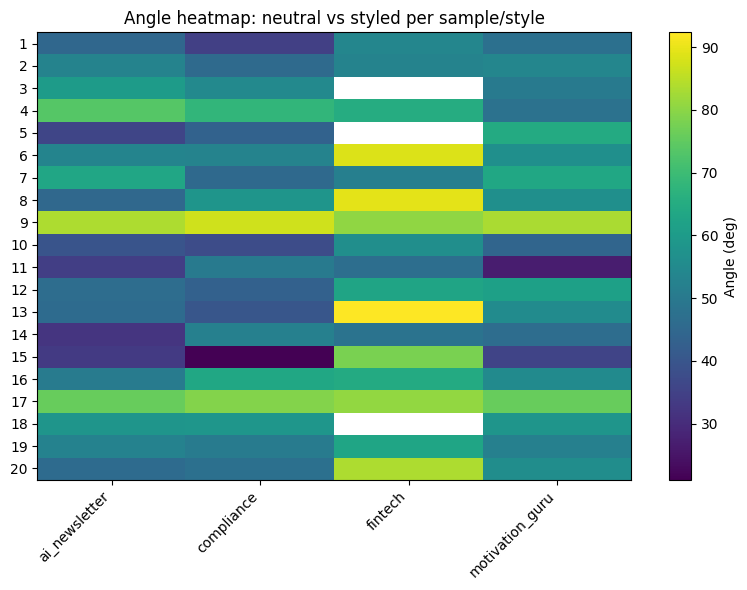

In [27]:
pivot = df_angles.pivot(index="id", columns="style", values="angle_deg").sort_index()

plt.figure(figsize=(8,6))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="Angle (deg)")
plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
plt.title("Angle heatmap: neutral vs styled per sample/style")
plt.tight_layout()
plt.show()


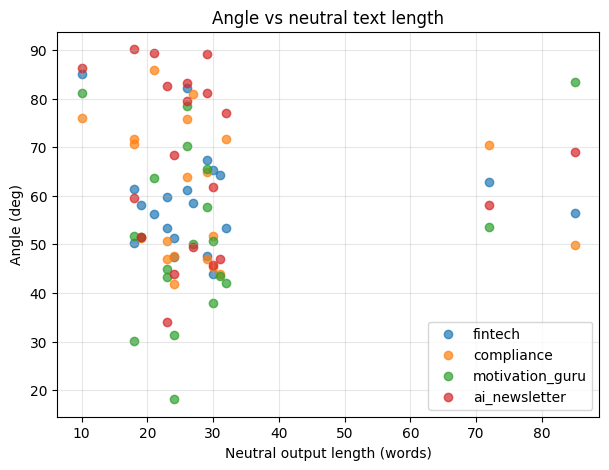

In [24]:
STYLES = ["fintech", "compliance", "motivation_guru", "ai_newsletter"]

length_map = df_base.set_index("id")["neutral_out"].apply(lambda s: len(s.split()))
df_angles["neutral_len"] = df_angles["id"].map(length_map)

plt.figure(figsize=(7,5))
for style in STYLES:
    sub = df_angles[df_angles["style"] == style]
    plt.scatter(sub["neutral_len"], sub["angle_deg"], label=style, alpha=0.7)

plt.xlabel("Neutral output length (words)")
plt.ylabel("Angle (deg)")
plt.title("Angle vs neutral text length")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


df_styles columns: ['Unnamed: 0', 'id', 'style', 'src', 'neutral_out', 'styled_out']
df_base columns: ['Unnamed: 0', 'id', 'text', 'neutral_out']


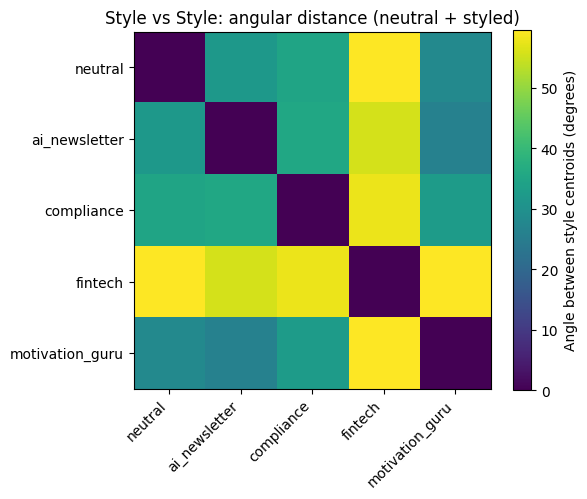

In [31]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# --- 1. Загрузка данных из CSV (если ещё не загружены) ---

df_styles = pd.read_csv("test_results_brak.csv")
df_base   = pd.read_csv("test_results_neutral_brak.csv")

print("df_styles columns:", df_styles.columns.tolist())
print("df_base columns:", df_base.columns.tolist())

# Приводим имена колонок к ожидаемым, если нужно:
if "neutral_out" not in df_base.columns:
    if "output" in df_base.columns:
        df_base = df_base.rename(columns={"output": "neutral_out"})
    elif "text" in df_base.columns:
        df_base = df_base.rename(columns={"text": "neutral_out"})
    else:
        raise RuntimeError("Cannot find neutral text column in df_base")

if "styled_out" not in df_styles.columns:
    if "output" in df_styles.columns:
        df_styles = df_styles.rename(columns={"output": "styled_out"})
    elif "text" in df_styles.columns:
        df_styles = df_styles.rename(columns={"text": "styled_out"})
    else:
        raise RuntimeError("Cannot find styled text column in df_styles")

# Чистим NaN и приводим к строкам
df_base["neutral_out"]  = df_base["neutral_out"].fillna("").astype(str)
df_styles["styled_out"] = df_styles["styled_out"].fillna("").astype(str)
df_styles["style"]      = df_styles["style"].astype(str)

# --- 2. Модель эмбеддингов и функция для угла ---

emb_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def cosine_angle(v1: np.ndarray, v2: np.ndarray):
    """
    Возвращает (angle_deg, cosine_similarity) между двумя векторами.
    """
    v1 = v1 / (np.linalg.norm(v1) + 1e-8)
    v2 = v2 / (np.linalg.norm(v2) + 1e-8)
    cos_sim = float(np.clip(np.dot(v1, v2), -1.0, 1.0))
    angle = math.degrees(math.acos(cos_sim))
    return angle, cos_sim

# --- 3. Считаем центроиды для neutral и каждого стиля ---

centroids = {}

# 3.1. Центроид neutral (базовая модель)
neutral_texts = df_base["neutral_out"].tolist()
neutral_embs  = emb_model.encode(neutral_texts, convert_to_numpy=True)
centroids["neutral"] = neutral_embs.mean(axis=0)

# 3.2. Центроиды для каждого стиля
styles = sorted(df_styles["style"].unique().tolist())

for style in styles:
    sub = df_styles[df_styles["style"] == style]
    texts = sub["styled_out"].tolist()
    # защита от пустоты
    texts = [t for t in texts if isinstance(t, str) and t.strip()]
    if not texts:
        continue
    embs = emb_model.encode(texts, convert_to_numpy=True)
    centroids[style] = embs.mean(axis=0)

# --- 4. Строим матрицу углов "стиль ↔ стиль" ---

labels = ["neutral"] + styles  # neutral как baseline
n = len(labels)

angle_matrix = np.zeros((n, n), dtype=float)

for i, s1 in enumerate(labels):
    for j, s2 in enumerate(labels):
        v1 = centroids[s1]
        v2 = centroids[s2]
        angle_deg, _ = cosine_angle(v1, v2)
        angle_matrix[i, j] = angle_deg

# --- 5. Heatmap: углы между стилями ---

plt.figure(figsize=(6, 5))
im = plt.imshow(angle_matrix, aspect="equal")

plt.colorbar(im, label="Angle between style centroids (degrees)")
plt.xticks(ticks=np.arange(n), labels=labels, rotation=45, ha="right")
plt.yticks(ticks=np.arange(n), labels=labels)
plt.title("Style vs Style: angular distance (neutral + styled)")
plt.tight_layout()
plt.show()

